#Import Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

file_path_true = "/content/drive/My Drive/Autumn 2025/Aritificial Intelligence Principles and Applications/AT3/WELFake_Dataset.csv"
# file_path_true = "/content/drive/My Drive/WELFake_Dataset.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

df = pd.read_csv(file_path_true)
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


#Data preprocessing

In [5]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [6]:
#Drop the missing value
df.dropna(subset=['title', 'text'], inplace=True)

In [7]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
# Combine title and text, and convert to lowercase
df['combined_text'] = (df['title'] + " " + df['text']).str.lower()

df.head()

,Unnamed: 0,title,text,label,combined_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,law enforcement on high alert following threat...
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,unbelievable! obama’s attorney general says mo...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"bobby jindal, raised hindu, uses story of chri..."
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,satan 2: russia unvelis an image of its terrif...
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,about time! christian group sues amazon and sp...


In [9]:
df = df[df['label'].apply(lambda x: str(x).isdigit())]
df['label'].astype(int)
df['label'] = 1 - df['label']

#Feature Engineering

##Titel and Text length

In [10]:
# Create new features
df['title_len'] = df['title'].astype(str).apply(len)
df['text_len'] = df['text'].astype(str).apply(len)

# Preview the result
print(df[['title', 'title_len', 'text_len']].head())

                                               title  title_len  text_len
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...        130      5049
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...        137       216
3  Bobby Jindal, raised Hindu, uses story of Chri...        105      8010
4  SATAN 2: Russia unvelis an image of its terrif...         95      1916
5  About Time! Christian Group Sues Amazon and SP...         78      1530


In [11]:
df["text_len"].describe()

,text_len
count,71537.000000
mean,3292.722116
std,3738.194002
min,1.000000
25%,1410.000000
50%,2440.000000
75%,4077.000000
max,142961.000000


##Combined text length

In [12]:
df['combined_text_len'] = df['combined_text'].astype(str).apply(len)

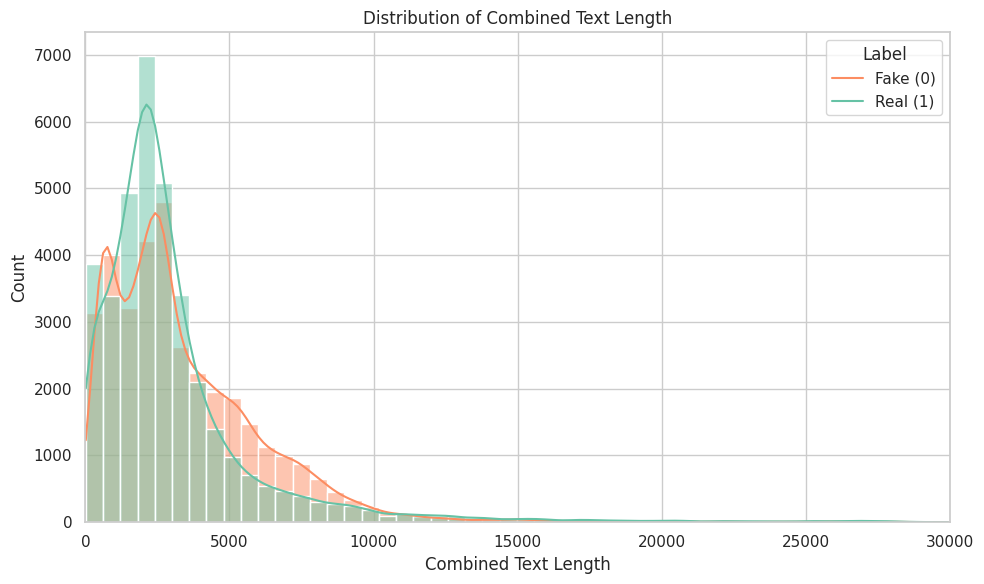

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['combined_text_len'] < 30000],
             x='combined_text_len',
             hue='label',
             bins=50,
             kde=True,
             palette='Set2')

plt.title('Distribution of Combined Text Length')
plt.xlabel('Combined Text Length')
plt.xlim(0, 30000)
plt.legend(title='Label', labels=['Fake (0)', 'Real (1)'])
plt.tight_layout()
plt.show()

### 📊 Feature: `combined_text_length`

**Interpretation**:  
The distribution shows that real news articles (Label 1) tend to have slightly **longer combined text lengths** than fake news articles (Label 0). Both distributions are right-skewed, but the real news peaks around 3000–4000 characters, while fake news has a flatter distribution with more short-length articles.

**Recommendation**: ✅ **Keep this feature**  
Text length is a useful auxiliary signal. It can help distinguish fake from real articles, especially in models like RoBERTa when used as an additional input alongside embeddings. You could also use it for filtering or padding strategies if fine-tuning.

> 🔧 Optional: You could consider **bucketing or normalizing** this feature before adding it to your model, or even use it to filter outliers.

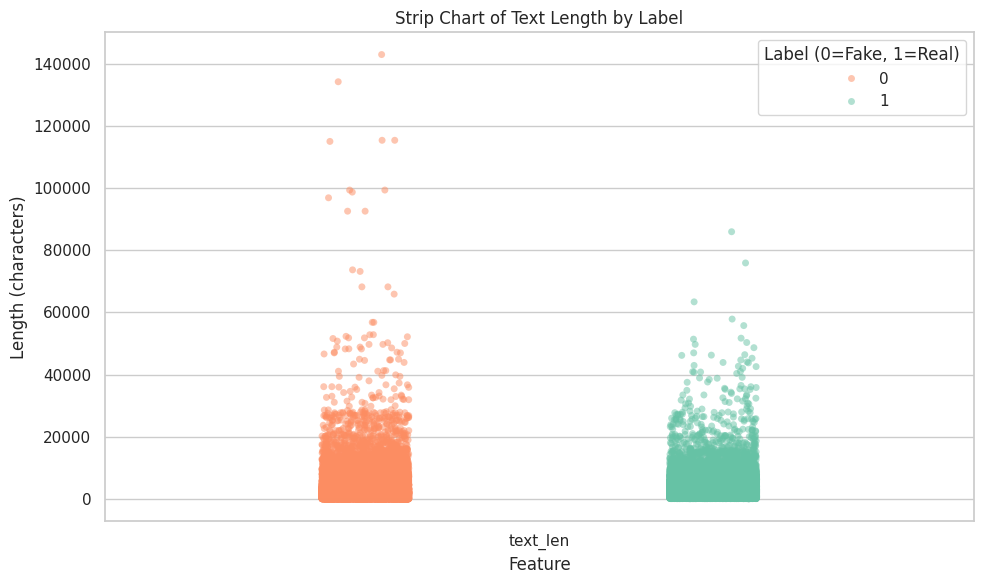

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape including label
length_df = df[['label', 'text_len']].melt(id_vars='label', var_name='Feature', value_name='Length')

# Plot as strip chart with swapped colors
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=length_df,
    x='Feature',
    y='Length',
    hue='label',
    palette={0: '#FC8D62', 1: '#66C2A5'},  # Swapped colors
    dodge=True,
    jitter=True,
    alpha=0.5
)
plt.title('Strip Chart of Text Length by Label')
plt.xlabel('Feature')
plt.ylabel('Length (characters)')
plt.legend(title='Label (0=Fake, 1=Real)')
plt.tight_layout()
plt.show()

### 📊 Feature: `text_len` (Length of Text by Label)

**Interpretation**:  
This strip chart shows that **fake news articles (Label 0)** tend to have more outliers and a wider spread in text length, including many **very long articles (above 100,000 characters)**. In contrast, **real news articles (Label 1)** have a more compact and consistent range, with fewer extreme values.

This suggests that fake news may include long-winded or bloated narratives, while real news maintains a more standard editorial length.

**Recommendation**: ✅ **Keep this feature**  
Text length clearly differentiates the two classes in terms of distribution and outliers. For RoBERTa, although it uses tokenized input, this feature can serve as a **supplemental input or filtering criterion** (e.g., remove extremely long articles that exceed token limits).

> 🔧 Optional: You might also experiment with trimming or capping extremely long texts to the RoBERTa max token limit (e.g., 512 or 1024).

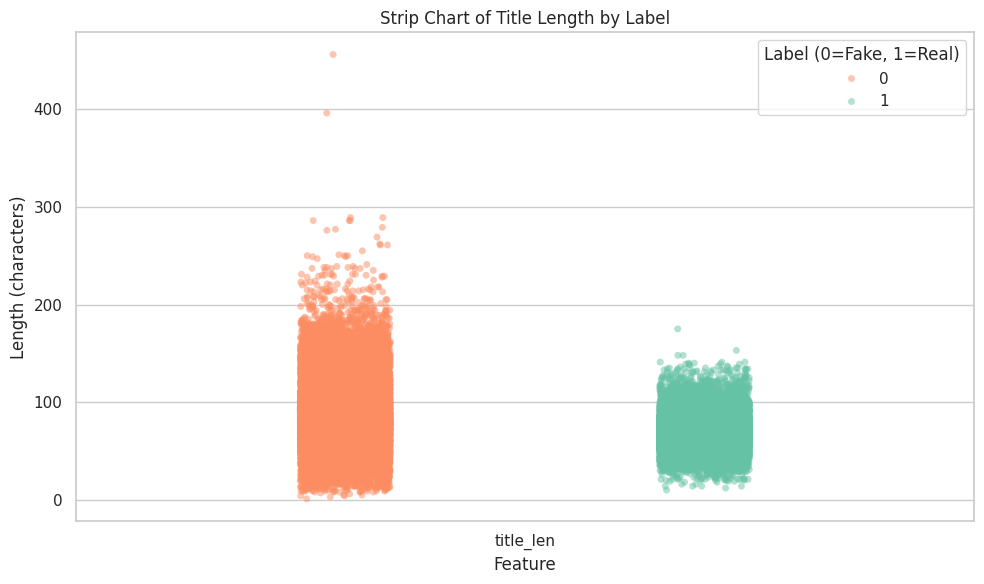

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape including label
length_df = df[['label', 'title_len']].melt(id_vars='label', var_name='Feature', value_name='Length')

custom_palette = {0: sns.color_palette("Set2")[1], 1: sns.color_palette("Set2")[0]}

# Plot as strip chart with swapped colors
plt.figure(figsize=(10, 6))
sns.stripplot(data=length_df, x='Feature', y='Length', hue='label', palette=custom_palette, dodge=True, jitter=True, alpha=0.5)
plt.title('Strip Chart of Title Length by Label')
plt.xlabel('Feature')
plt.ylabel('Length (characters)')
plt.legend(title='Label (0=Fake, 1=Real)')
plt.tight_layout()
plt.show()

### 📊 Feature: `title_len` (Title Length by Label)

**Interpretation**:  
The chart shows that **fake news titles (Label 0)** are generally longer, with several outliers exceeding 200 characters. In contrast, **real news titles (Label 1)** are more concise and fall within a narrower range, typically under 150 characters.

This suggests that fake news articles often use longer, more sensational headlines to attract clicks, while real news headlines are more direct and standardized.

**Recommendation**: ✅ **Keep this feature**  
Title length is a strong stylistic indicator of news type and can enhance RoBERTa’s ability to detect patterns when combined with token embeddings. You can either:
- Use it as an **auxiliary numeric feature**, or
- Let RoBERTa implicitly capture this via token count, but it’s still valuable for interpretability and potential hybrid models.

> 🛠️ Tip: Normalize this feature if integrating it with RoBERTa outputs in a mixed (hybrid) architecture.

##Average word length

In [16]:
def avg_word_length(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0
    words = text.split()
    word_lengths = [len(word) for word in words]
    return sum(word_lengths) / len(words)

# Apply to your DataFrame
df['avg_word_len'] = df['combined_text'].apply(avg_word_length)


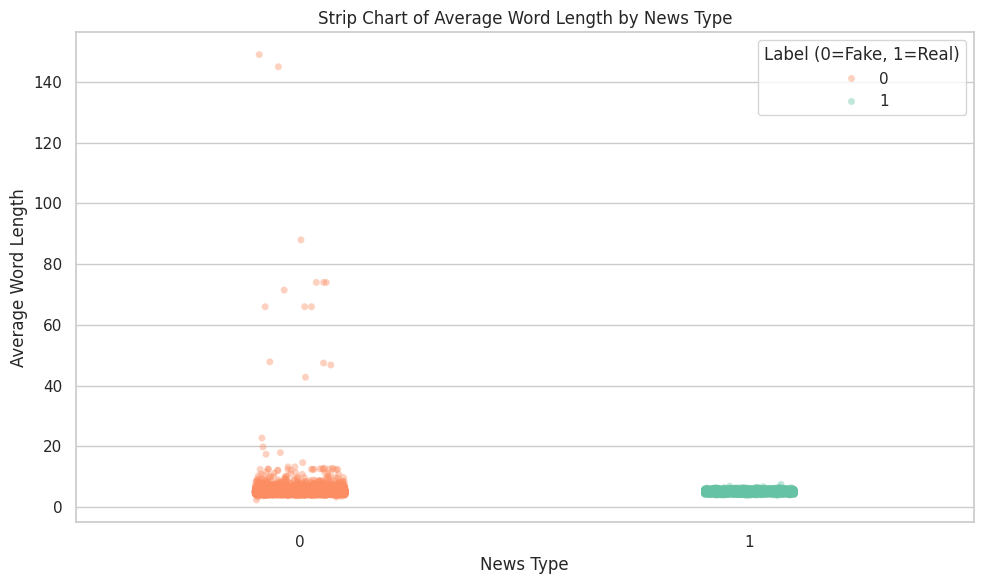

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot as strip chart
plt.figure(figsize=(10, 6))
sns.stripplot(x='label', y='avg_word_len', hue='label',data=df, jitter=True, alpha=0.4, palette=custom_palette)
plt.title('Strip Chart of Average Word Length by News Type')
plt.xlabel('News Type')
plt.ylabel('Average Word Length')
plt.legend(title='Label (0=Fake, 1=Real)')
plt.tight_layout()
plt.show()

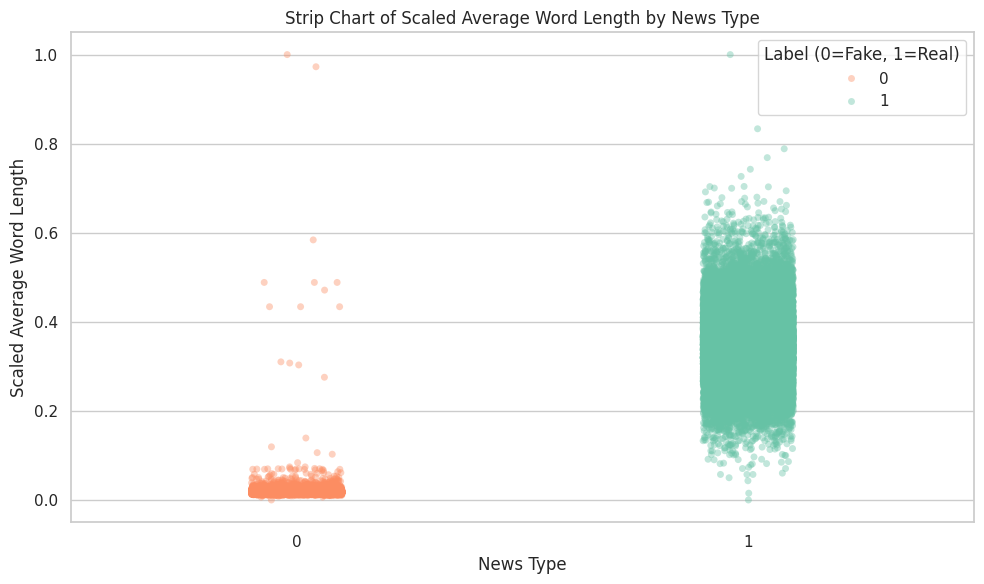

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set plot style
sns.set(style="whitegrid")

# Separate scaling for each label group
df_scaled = df.copy()
scaler = MinMaxScaler()

for label in df['label'].unique():
    mask = df['label'] == label
    df_scaled.loc[mask, 'scaled_avg_word_len'] = scaler.fit_transform(df.loc[mask, ['avg_word_len']])

# Strip plot with scaled values
plt.figure(figsize=(10, 6))
sns.stripplot(x='label', y='scaled_avg_word_len', hue='label',
              data=df_scaled, jitter=True, alpha=0.4, palette=custom_palette)

plt.title('Strip Chart of Scaled Average Word Length by News Type')
plt.xlabel('News Type')
plt.ylabel('Scaled Average Word Length')
plt.legend(title='Label (0=Fake, 1=Real)')
plt.tight_layout()
plt.show()

### 📊 Feature: `scaled_avg_word_len` (Min-Max Scaled Average Word Length by News Type)

**Interpretation**:  
This strip chart shows a **distinct separation** in scaled average word length between fake (Label 0) and real news (Label 1). Fake news articles cluster around lower scaled values (closer to 0), while real news articles are distributed across a higher scaled range. This suggests that real news tends to use longer or more complex words, while fake news often relies on simpler language.

**Recommendation**: ✅ **Keep this feature**  
Even though RoBERTa tokenizes input into subwords, this feature captures a **global linguistic pattern** that can enhance model interpretability or be used in a hybrid or ensemble setup. Min-Max scaling makes it ready for numeric input into neural layers or concatenation with embeddings.

> 🛠️ Good job using Min-Max scaling! You can directly concatenate this with other auxiliary features in a late-fusion architecture.

##Number of Exclamation mark and Question mark

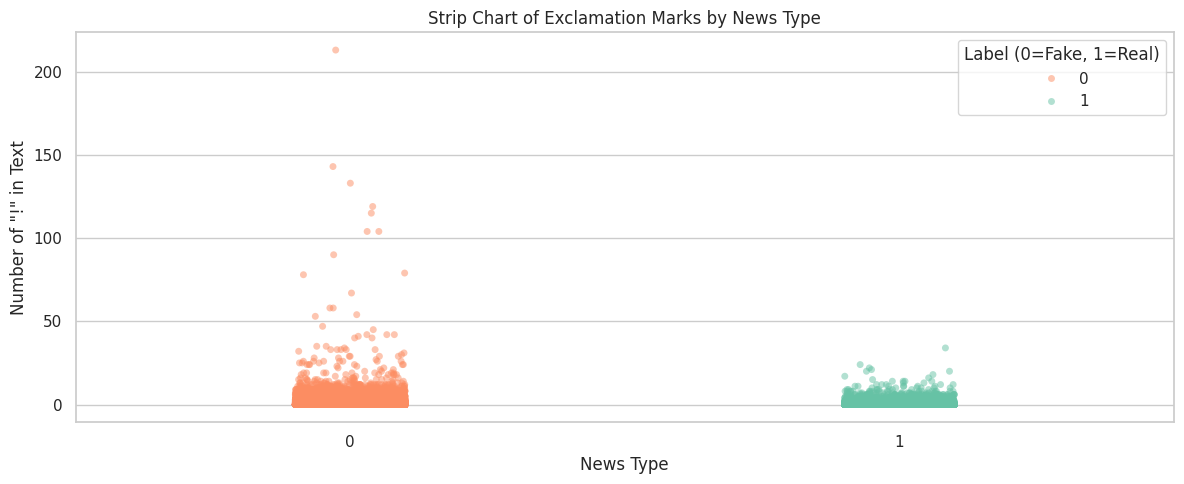

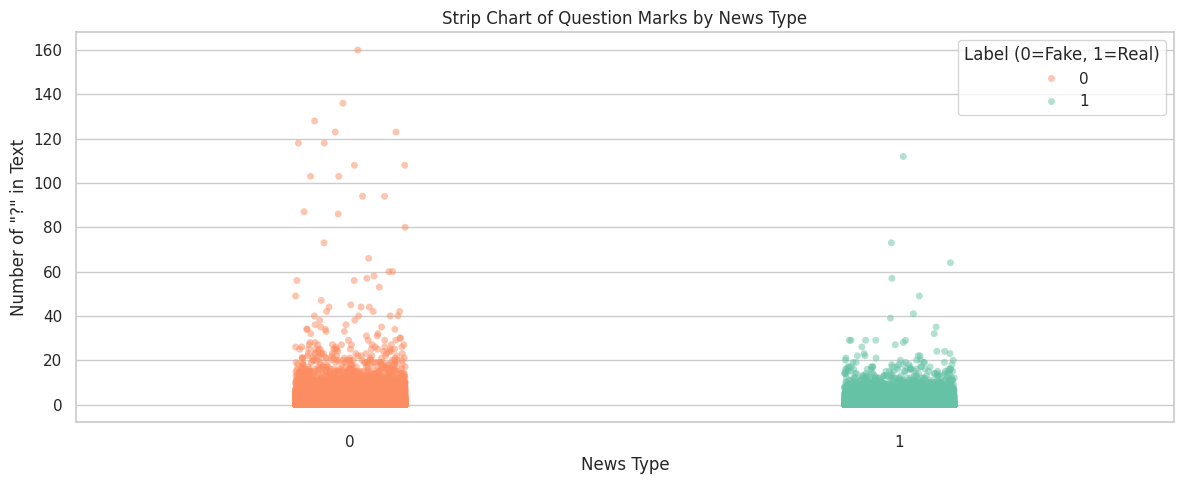

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create features
df['num_exclam'] = df['combined_text'].str.count('!')
df['num_question'] = df['combined_text'].str.count('\?')

# Set seaborn style
sns.set(style='whitegrid')

# Strip plot for exclamation marks
plt.figure(figsize=(12, 5))
sns.stripplot(x='label', y='num_exclam', hue='label', data=df, jitter=True, alpha=0.5,
              palette=custom_palette, dodge=False)
plt.title('Strip Chart of Exclamation Marks by News Type')
plt.xlabel('News Type')
plt.ylabel('Number of "!" in Text')
plt.legend(title='Label (0=Fake, 1=Real)')
plt.tight_layout()
plt.show()

# Strip plot for question marks
plt.figure(figsize=(12, 5))
sns.stripplot(x='label', y='num_question', hue='label', data=df, jitter=True, alpha=0.5,
              palette=custom_palette, dodge=False)
plt.title('Strip Chart of Question Marks by News Type')
plt.xlabel('News Type')
plt.ylabel('Number of "?" in Text')
plt.legend(title='Label (0=Fake, 1=Real)')
plt.tight_layout()
plt.show()

### 📊 Feature: `exclamation_count` (Number of "!" in Text by News Type)

**Interpretation**:  
This strip chart shows that **fake news articles (Label 0)** contain significantly more exclamation marks than real news (Label 1). Many fake articles use 10–50 exclamation marks, with some extreme outliers exceeding 50. In contrast, real news rarely uses exclamation marks and is tightly clustered near zero.

This aligns with known fake news patterns, where exaggerated punctuation is used for sensationalism and emotional manipulation.

**Recommendation**: ✅ **Keep this feature**  
The separation is **clear and meaningful**. Even though RoBERTa can model punctuation contextually, explicitly counting exclamations adds interpretability and can reinforce style-based signals in hybrid models.

> 🧠 Tip: You can also explore similar stylistic features like question marks, ellipses (`...`), or repeated punctuation for richer expressiveness.

### 📊 Feature: `question_count` (Number of "?" in Text by News Type)

**Interpretation**:  
This strip chart shows that **fake news articles (Label 0)** tend to use significantly more question marks than real news (Label 1), often ranging from 10 to over 100 in extreme cases. Real news rarely exceeds 20 question marks and is more tightly distributed near zero.

This supports the idea that fake news frequently uses rhetorical or leading questions to provoke curiosity, doubt, or fear — a common tactic in misinformation.

**Recommendation**: ✅ **Keep this feature**  
The distinction is **clear and meaningful**. This stylistic marker adds value beyond RoBERTa’s token embeddings by highlighting tone and writing style. Especially useful for feature-rich or hybrid classification pipelines.

> 💬 Optional: You can combine `question_count` and `exclamation_count` into a **"sensationalism_score"** to capture exaggerated punctuation patterns.

##Sentiment analysis

In [20]:
!pip install textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [21]:
from textblob import TextBlob

# Function to compute sentiment
def get_sentiment(text):
    blob = TextBlob(str(text))
    return pd.Series([blob.polarity, blob.subjectivity])

# Apply on title
df[['sentiment_title_polarity', 'sentiment_title_subjectivity']] = df['title'].apply(get_sentiment)

# Apply on text
df[['sentiment_text_polarity', 'sentiment_text_subjectivity']] = df['text'].apply(get_sentiment)

# Check result
print(df[['title', 'sentiment_title_polarity', 'sentiment_title_subjectivity']].head())


                                               title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   
5  About Time! Christian Group Sues Amazon and SP...   

   sentiment_title_polarity  sentiment_title_subjectivity  
0                  0.080000                      0.320000  
2                  0.121875                      0.625000  
3                  0.000000                      0.500000  
4                 -0.287879                      0.484848  
5                 -0.400000                      0.450000  


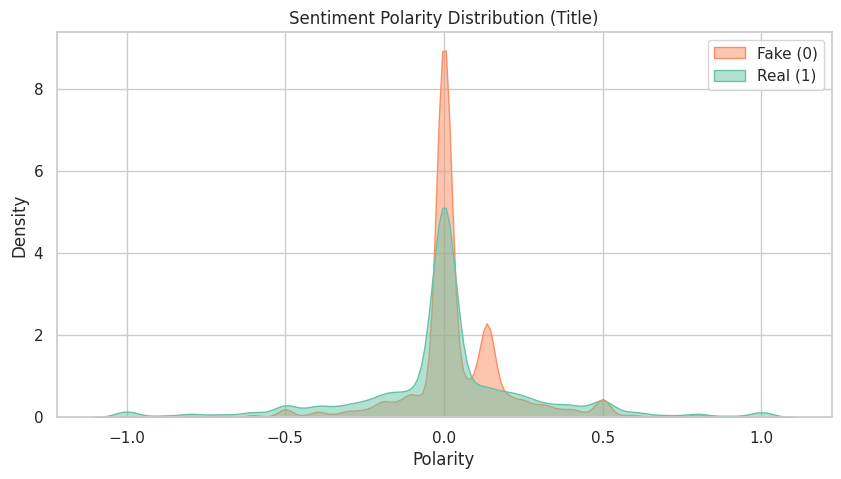

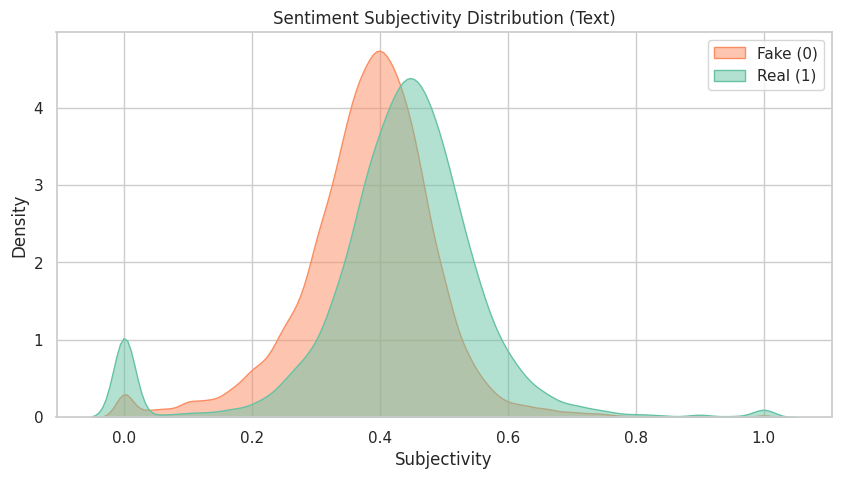

In [22]:
# Set style
sns.set(style="whitegrid")

# Plot 1: Polarity distribution for titles (by label)
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='sentiment_title_polarity', hue='label', fill=True, common_norm=False, alpha=0.5, palette='Set2')
plt.title('Sentiment Polarity Distribution (Title)')
plt.xlabel('Polarity')
plt.legend(labels=["Fake (0)", "Real (1)"])
plt.show()

# Plot 2: Subjectivity distribution for text (by label)
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='sentiment_text_subjectivity', hue='label', fill=True, common_norm=False, alpha=0.5, palette='Set2')
plt.title('Sentiment Subjectivity Distribution (Text)')
plt.xlabel('Subjectivity')
plt.legend(labels=["Fake (0)", "Real (1)"])
plt.show()

### 📊 Feature: `title_sentiment_polarity` (Sentiment Polarity of News Titles)

**Interpretation**:  
This density plot shows that **fake news titles (Label 0)** are more sharply centered around **neutral polarity (0)**, but with a **distinct secondary bump on the positive side** (around 0.2–0.3). Real news (Label 1), while also mostly neutral, shows a **wider distribution** and more balanced spread across positive and negative values.

This suggests fake news often tries to appear neutral or slightly optimistic in tone, while real news captures a broader emotional spectrum.

**Recommendation**: ✅ **Keep this feature**  
Even though the differences are subtle, sentiment polarity can help detect **tonal patterns** and **emotional framing** typical of fake headlines. When combined with other features (e.g., punctuation, question marks), it enhances overall model expressiveness.

> 📉 Tip: Consider adding **subjectivity score** as a complementary feature to assess bias or opinionated tone.

### 📊 Feature: `text_subjectivity` (Sentiment Subjectivity of News Text)

**Interpretation**:  
This density plot reveals that **fake news articles (Label 0)** have a **higher concentration around a subjectivity score of ~0.4**, indicating a moderately opinionated tone. In contrast, **real news (Label 1)** shows a slightly **broader and more right-shifted distribution**, with a portion extending towards higher subjectivity (up to 1.0) and a **small spike at 0**, suggesting some objective reporting.

This implies that **fake news generally maintains a consistent level of subjectivity**, while **real news varies more**, ranging from factual reporting to opinionated editorials.

**Recommendation**: ✅ **Keep this feature**  
Subjectivity is a valuable signal. It reflects **tone consistency** and helps differentiate **opinion-heavy misinformation** from **fact-based journalism**. RoBERTa might not explicitly capture this unless trained extensively on sentiment tasks, so including it as a structured feature can add complementary value.

> 💡 Suggestion: You may also explore **combining polarity and subjectivity** into a joint feature (e.g., polarity × subjectivity) to emphasize emotionally biased language.

##Flesch and Gunning score


In [23]:
# !pip install textstat

In [24]:
# import textstat
# from tqdm import tqdm

# # If not already using tqdm for progress tracking
# tqdm.pandas()

# # Assuming your DataFrame is named df and contains 'text' and 'title' columns

# # Flesch Reading Ease: higher = easier to read
# df['text_flesch'] = df['text'].progress_apply(lambda x: textstat.flesch_reading_ease(str(x)))
# df['title_flesch'] = df['title'].progress_apply(lambda x: textstat.flesch_reading_ease(str(x)))

# # Gunning Fog Index: higher = more complex (aim for 7-8 for standard English)
# df['text_gunning'] = df['text'].progress_apply(lambda x: textstat.gunning_fog(str(x)))
# df['title_gunning'] = df['title'].progress_apply(lambda x: textstat.gunning_fog(str(x)))

In [25]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Set Seaborn style
# sns.set(style="whitegrid")

# # Set figure size
# plt.figure(figsize=(14, 6))

# # 1. Flesch Reading Ease - Text
# plt.subplot(1, 2, 1)
# sns.kdeplot(data=df, x="text_flesch", hue="label", fill=True, common_norm=False, palette="Set2")
# plt.title("Flesch Reading Ease (Text)\nHigher = Easier to Read")
# plt.xlabel("Flesch Score")
# plt.ylabel("Density")
# plt.legend(title="Label", labels=["Fake", "Real"])
# plt.xlim(0, 100)  # Flesch is naturally between 0–100

# # 2. Gunning Fog Index - Text (LIMITED to 0–100)
# plt.subplot(1, 2, 2)
# sns.kdeplot(data=df[df["text_gunning"] <= 100], x="text_gunning", hue="label", fill=True, common_norm=False, palette="Set2")
# plt.title("Gunning Fog Index (Text)\nHigher = More Complex")
# plt.xlabel("Fog Index")
# plt.ylabel("Density")
# plt.legend(title="Label", labels=["Fake", "Real"])
# plt.xlim(0, 100)

# plt.tight_layout()
# plt.show()

In [26]:
# # 1. Flesch Reading Ease - title
# plt.subplot(1, 2, 1)
# sns.kdeplot(data=df, x="title_flesch", hue="label", fill=True, common_norm=False, palette="Set2")
# plt.title("Flesch Reading Ease (title)\nHigher = Easier to Read")
# plt.xlabel("Flesch Score")
# plt.ylabel("Density")
# plt.legend(title="Label", labels=["Fake", "Real"])
# plt.xlim(0, 100)  # Flesch is naturally between 0–100

# # 2. Gunning Fog Index - title (LIMITED to 0–100)
# plt.subplot(1, 2, 2)
# sns.kdeplot(data=df[df["title_gunning"] <= 100], x="title_gunning", hue="label", fill=True, common_norm=False, palette="Set2")
# plt.title("Gunning Fog Index (title)\nHigher = More Complex")
# plt.xlabel("Fog Index")
# plt.ylabel("Density")
# plt.legend(title="Label", labels=["Fake", "Real"])
# plt.xlim(0, 100)


##Lexical diversity

In [27]:
import pandas as pd

def lexical_diversity(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0
    words = text.split()
    return len(set(words)) / len(words) if len(words) > 0 else 0

# Apply to your dataframe
df['lexical_diversity'] = df['combined_text'].apply(lexical_diversity)

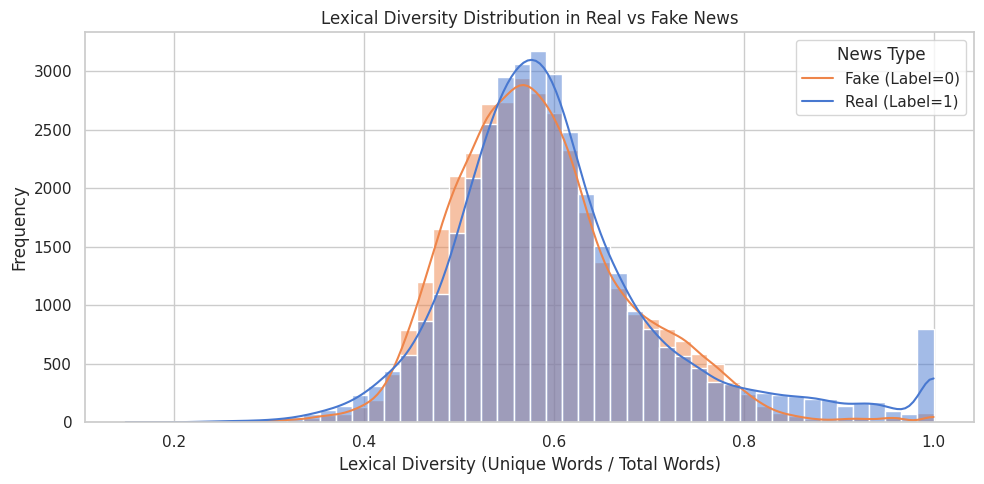

In [28]:
# Plot lexical diversity distribution by class
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='lexical_diversity', hue='label', bins=50, kde=True, palette='muted')
plt.title('Lexical Diversity Distribution in Real vs Fake News')
plt.xlabel('Lexical Diversity (Unique Words / Total Words)')
plt.ylabel('Frequency')
plt.legend(title='News Type', labels=['Fake (Label=0)', 'Real (Label=1)'])
plt.tight_layout()
plt.show()

### 📊 Feature: `lexical_diversity` (Unique Words / Total Words)

**Interpretation**:  
This plot shows that **real news articles (Label 1)** tend to have slightly **higher lexical diversity**, peaking around **0.58**, whereas **fake news (Label 0)** is centered closer to **0.55** with a longer tail toward lower diversity scores.

Lexical diversity measures how varied the vocabulary is. A higher score suggests richer, more varied language, while lower scores indicate more repetitive or generic word usage.

This pattern suggests that real news generally uses a **broader and more precise vocabulary**, while fake news might reuse more common terms, possibly to appeal to a general audience or due to automated generation.

**Recommendation**: ✅ **Keep this feature**  
Lexical diversity is a strong stylistic indicator. It helps capture **content quality and linguistic variety**, which can complement RoBERTa's token-level features, especially in distinguishing nuanced vs. repetitive language patterns.

> 🔍 Note: You may want to investigate the **spike at 1.0** — it could be due to very short texts where all words are unique (e.g., headlines or extremely short articles).

##Punctuation ratio and Stopword ratio

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


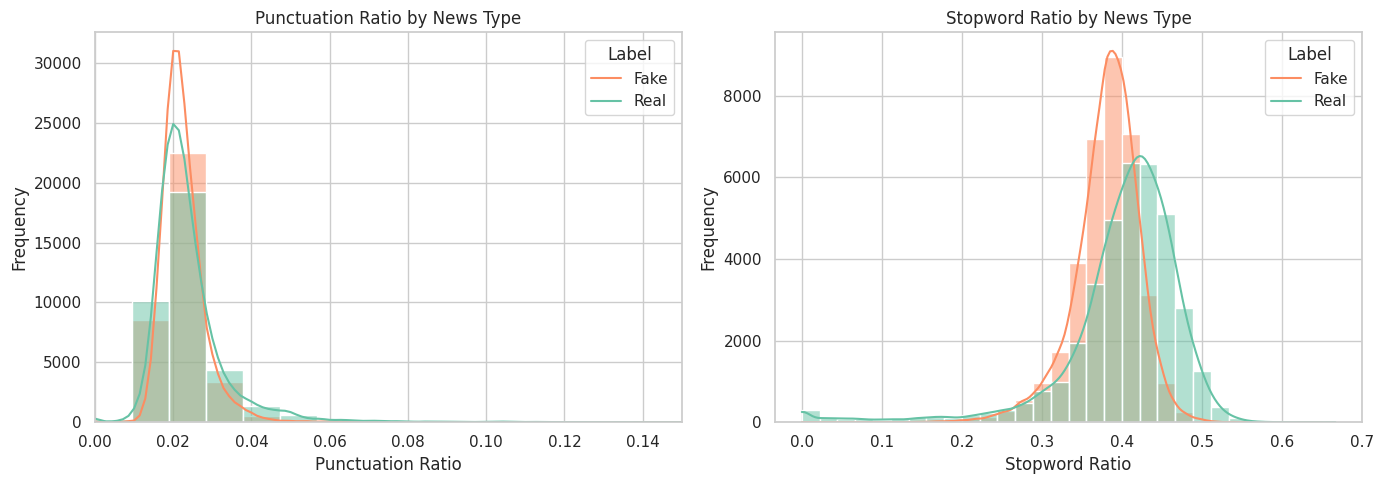

In [29]:
import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define feature functions
def punctuation_ratio(text):
    if not isinstance(text, str) or len(text) == 0:
        return 0
    punct_count = sum(1 for char in text if char in string.punctuation)
    return punct_count / len(text)

def stopword_ratio(text):
    if not isinstance(text, str) or len(text.split()) == 0:
        return 0
    words = text.split()
    stopword_count = sum(1 for word in words if word.lower() in stop_words)
    return stopword_count / len(words)

# Apply feature functions
df['punctuation_ratio'] = df['combined_text'].apply(punctuation_ratio)
df['stopword_ratio'] = df['combined_text'].apply(stopword_ratio)

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# Plot punctuation_ratio comparison (adjust x-axis range)
sns.histplot(data=df, x='punctuation_ratio', hue='label', bins=30, kde=True, ax=axes[0], palette='Set2')
axes[0].set_title('Punctuation Ratio by News Type')
axes[0].set_xlabel('Punctuation Ratio')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 0.15)
axes[0].legend(title='Label', labels=['Fake', 'Real'])

# Plot stopword_ratio comparison
sns.histplot(data=df, x='stopword_ratio', hue='label', bins=30, kde=True, ax=axes[1], palette='Set2')
axes[1].set_title('Stopword Ratio by News Type')
axes[1].set_xlabel('Stopword Ratio')
axes[1].set_ylabel('Frequency')
axes[1].legend(title='Label', labels=['Fake', 'Real'])

# Final layout
plt.tight_layout()
plt.show()

### 📊 Feature: `stopword_ratio` (Stopwords / Total Words)

**Interpretation**:  
The plot shows that **fake news (Label 0)** peaks at a **slightly lower stopword ratio** (~0.38), whereas **real news (Label 1)** tends to have a **higher stopword ratio**, peaking closer to **0.42**.

Stopwords are function words (e.g., *the, is, at*) that don't carry much meaning on their own but help with sentence structure. A higher ratio may reflect **more formal and grammatically complete writing**, which is often seen in professional journalism. A lower ratio might indicate **simpler, less structured, or more keyword-focused language**, common in fake news.

**Recommendation**: ✅ **Keep this feature**  
Stopword ratio captures subtle **linguistic style differences** that RoBERTa might not explicitly learn without fine-tuning on stylistic cues. It's useful in hybrid or feature-augmented models to reflect **fluency and writing style**.

> 🔍 You could also combine this with features like `punctuation_ratio` and `avg_word_length` to model general **writing sophistication**.

<ipython-input-30-3a6878617f24>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='label', y='punctuation_ratio', data=df, jitter=True, alpha=0.5, ax=axes[0], palette='Set2')
<ipython-input-30-3a6878617f24>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='label', y='stopword_ratio', data=df, jitter=True, alpha=0.5, ax=axes[1], palette='Set2')


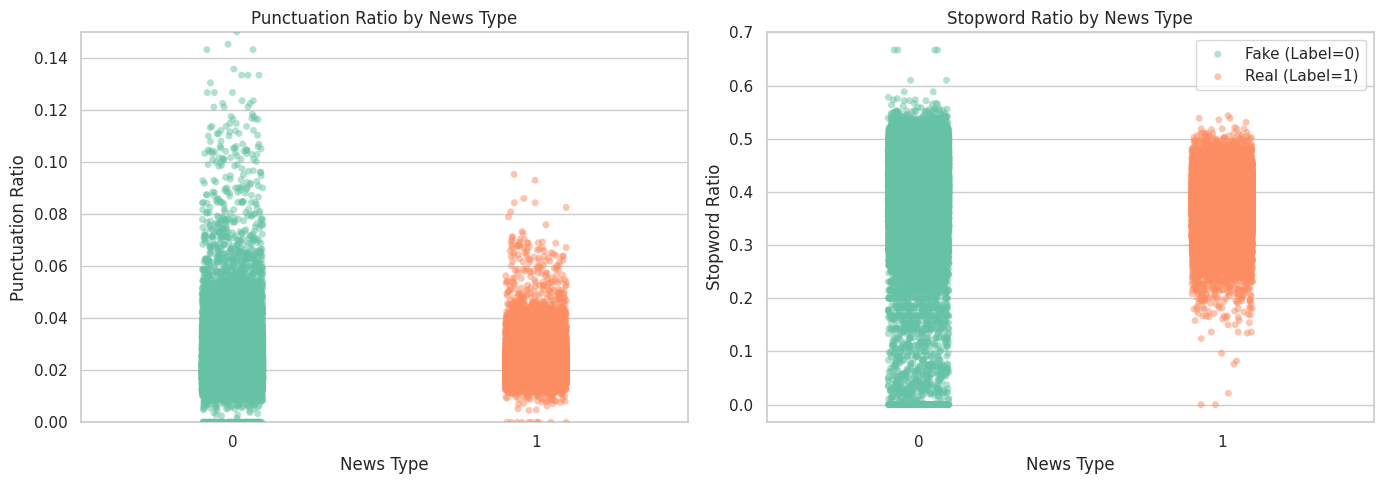

In [30]:
# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Punctuation ratio stripplot
sns.stripplot(x='label', y='punctuation_ratio', data=df, jitter=True, alpha=0.5, ax=axes[0], palette='Set2')
axes[0].set_title('Punctuation Ratio by News Type')
axes[0].set_xlabel('News Type')
axes[0].set_ylabel('Punctuation Ratio')
plt.legend(labels=['Fake (Label=0)', 'Real (Label=1)'])
axes[0].set_ylim(0, 0.15)

# Stopword ratio stripplot
sns.stripplot(x='label', y='stopword_ratio', data=df, jitter=True, alpha=0.5, ax=axes[1], palette='Set2')
axes[1].set_title('Stopword Ratio by News Type')
axes[1].set_xlabel('News Type')
axes[1].set_ylabel('Stopword Ratio')
plt.legend(labels=['Fake (Label=0)', 'Real (Label=1)'])

# Final layout
plt.tight_layout()
plt.show()

### 📊 Feature: `punctuation_ratio` (Punctuation Characters / Total Characters)

**Interpretation**:  
This plot shows that **real news (Label 1)** has a **lower punctuation ratio**, while **fake news (Label 0)** often has a **higher concentration of punctuation**, reaching up to 0.14. Fake articles appear to use punctuation more frequently, possibly for **dramatic or emotional effect** (e.g., excessive commas, ellipses, exclamation marks).

This supports the idea that fake news may rely on **emotive punctuation** to capture attention, whereas real news typically follows more formal editorial guidelines.

**Recommendation**: ✅ **Keep this feature**  
Punctuation ratio is a valuable stylistic signal that helps distinguish **emotional manipulation** vs. **objective reporting**. Even though RoBERTa learns contextual usage of tokens, this global ratio adds interpretability and can be used in ensemble or feature-augmented pipelines.

> ✍️ Tip: Combine with features like `exclamation_count` or `question_count` for a broader measure of **expressive writing style**.

#Modeling

In [31]:
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import make_pipeline

# Download resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function
stop_words = set(stopwords.words('english'))

# Add custom stopwords
additional_stopwords = {'reuters'}  # Add any words you want
stop_words.update(additional_stopwords)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(tokens)

# Apply preprocessing
df['clean_text'] = df['combined_text'].apply(preprocess_text)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df['clean_text'])

# Normalize numeric features
features_to_scale = [
    'avg_word_len', 'num_exclam', 'num_question',
    'sentiment_title_polarity', 'sentiment_title_subjectivity',
    'sentiment_text_polarity', 'sentiment_text_subjectivity',
    'lexical_diversity', 'punctuation_ratio', 'stopword_ratio'
]
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(df[features_to_scale])

# Combine TF-IDF and numeric features
from scipy.sparse import hstack
X_combined = hstack([X_tfidf, X_numeric_scaled])

# Labels
y = df['label']  # Adjust column name if needed

# Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train models
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
print("📊 Logistic Regression:\n", classification_report(y_test, logreg.predict(X_test)))

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train.toarray(), y_train)
print("🌳 Random Forest:\n", classification_report(y_test, rf.predict(X_test.toarray())))

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train.toarray(), y_train)
print("⚡ XGBoost:\n", classification_report(y_test, xgb.predict(X_test.toarray())))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


📊 Logistic Regression:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      7227
           1       0.92      0.92      0.92      7081

    accuracy                           0.92     14308
   macro avg       0.92      0.92      0.92     14308
weighted avg       0.92      0.92      0.92     14308

🌳 Random Forest:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      7227
           1       0.96      0.94      0.95      7081

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:46:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


⚡ XGBoost:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      7227
           1       0.97      0.96      0.96      7081

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


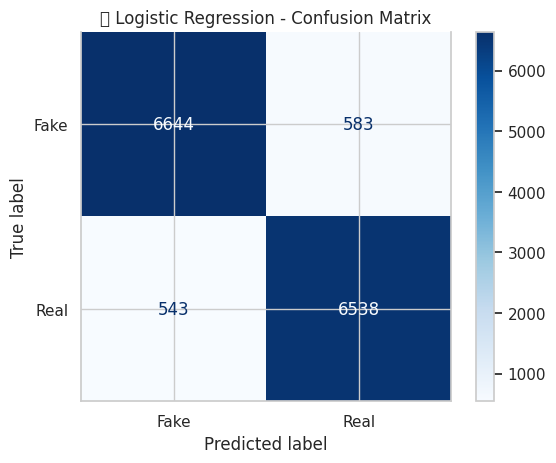

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


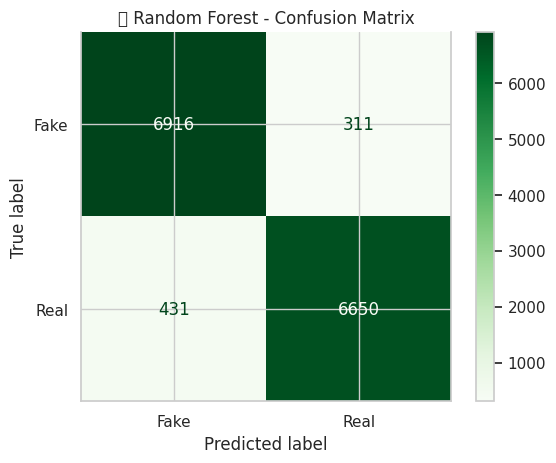

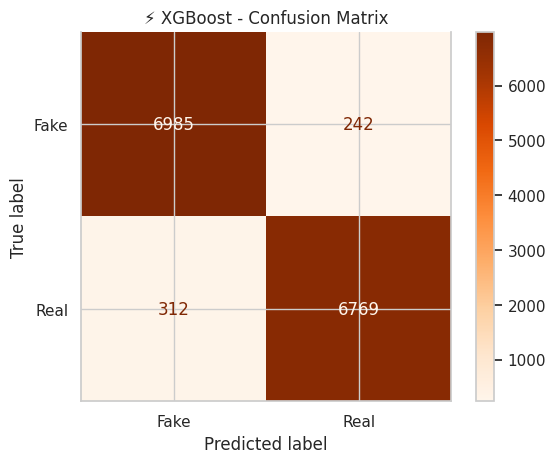

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression Confusion Matrix
y_pred_logreg = logreg.predict(X_test)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=["Fake", "Real"])
fig, ax = plt.subplots()
disp_logreg.plot(cmap='Blues', ax=ax)
ax.set_title("📊 Logistic Regression - Confusion Matrix")
ax.spines['top'].set_visible(False)  # remove top border
plt.show()

# Random Forest Confusion Matrix
y_pred_rf = rf.predict(X_test.toarray())
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Fake", "Real"])
fig, ax = plt.subplots()
disp_rf.plot(cmap='Greens', ax=ax)
ax.set_title("🌳 Random Forest - Confusion Matrix")
ax.spines['top'].set_visible(False)
plt.show()

# XGBoost Confusion Matrix
y_pred_xgb = xgb.predict(X_test.toarray())
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Fake", "Real"])
fig, ax = plt.subplots()
disp_xgb.plot(cmap='Oranges', ax=ax)
ax.set_title("⚡ XGBoost - Confusion Matrix")
ax.spines['top'].set_visible(False)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


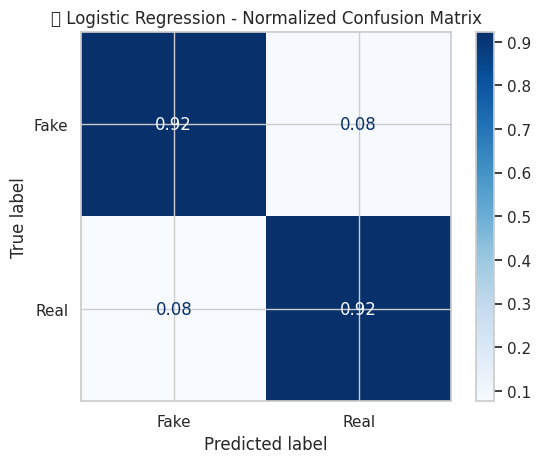

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


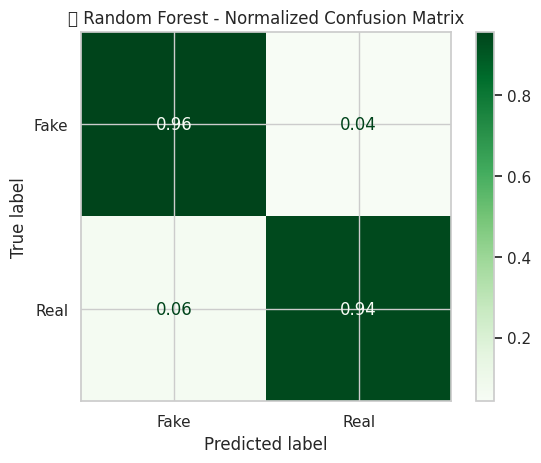

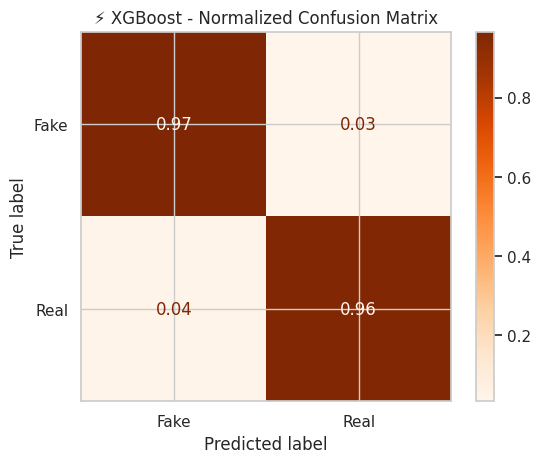

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression - Normalized
y_pred_logreg = logreg.predict(X_test)
cm_logreg = confusion_matrix(y_test, y_pred_logreg, normalize='true')
fig, ax = plt.subplots()
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=["Fake", "Real"])
disp_logreg.plot(cmap='Blues', values_format=".2f", ax=ax)
ax.set_title("📊 Logistic Regression - Normalized Confusion Matrix")
ax.spines['top'].set_visible(False)
plt.show()

# Random Forest - Normalized
y_pred_rf = rf.predict(X_test.toarray())
cm_rf = confusion_matrix(y_test, y_pred_rf, normalize='true')
fig, ax = plt.subplots()
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Fake", "Real"])
disp_rf.plot(cmap='Greens', values_format=".2f", ax=ax)
ax.set_title("🌳 Random Forest - Normalized Confusion Matrix")
ax.spines['top'].set_visible(False)
plt.show()

# XGBoost - Normalized
y_pred_xgb = xgb.predict(X_test.toarray())
cm_xgb = confusion_matrix(y_test, y_pred_xgb, normalize='true')
fig, ax = plt.subplots()
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Fake", "Real"])
disp_xgb.plot(cmap='Oranges', values_format=".2f", ax=ax)
ax.set_title("⚡ XGBoost - Normalized Confusion Matrix")
ax.spines['top'].set_visible(False)
plt.show()

##Feature Importance

In [34]:
# Get TF-IDF feature names
tfidf_feature_names = tfidf.get_feature_names_out()

# Combine with numeric feature names
all_feature_names = list(tfidf_feature_names) + features_to_scale

<ipython-input-35-aec493ce85b3>:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


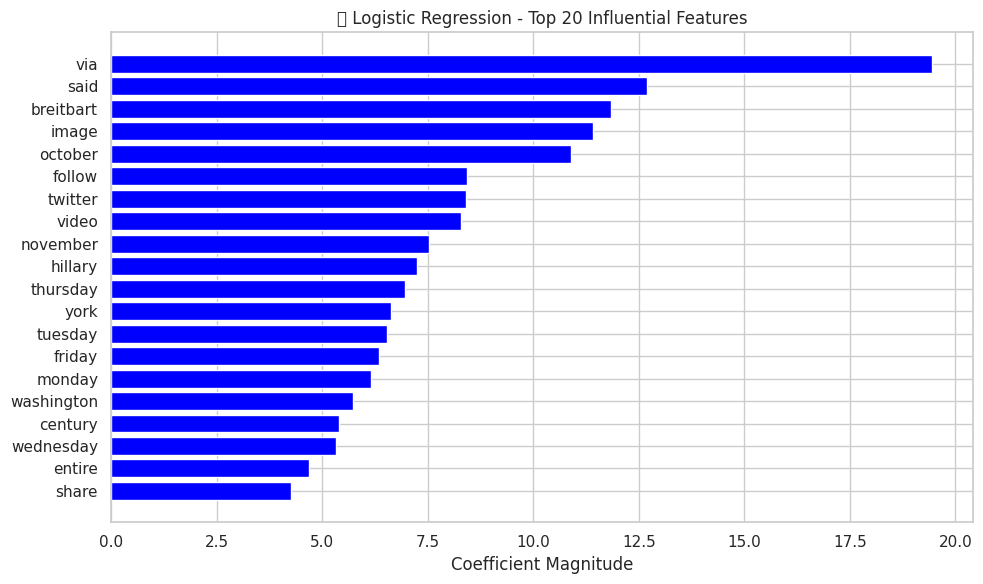

In [35]:
# Get coefficients and absolute values
logreg_coefs = np.abs(logreg.coef_[0])

# Sort top 20
logreg_indices = np.argsort(logreg_coefs)[-20:][::-1]
top_logreg_features = [all_feature_names[i] for i in logreg_indices]
top_logreg_importance = logreg_coefs[logreg_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_logreg_features[::-1], top_logreg_importance[::-1], color='blue')
plt.xlabel("Coefficient Magnitude")
plt.title("📊 Logistic Regression - Top 20 Influential Features")
plt.tight_layout()
plt.show()

<ipython-input-36-7bde5ee3e08f>:16: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


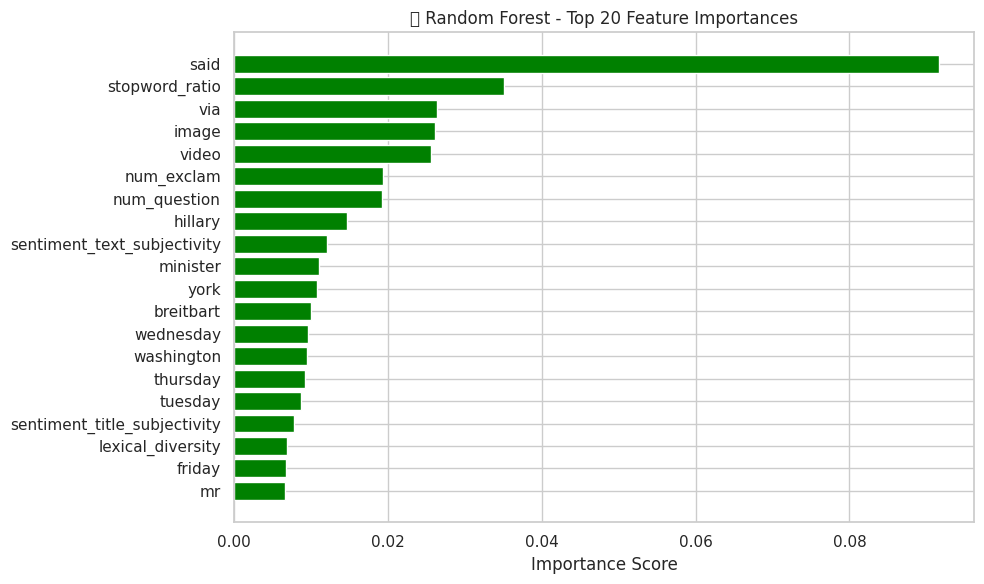

In [36]:
import numpy as np

# Get feature importances
rf_importances = rf.feature_importances_

# Sort top 20 features
rf_indices = np.argsort(rf_importances)[-20:][::-1]
top_rf_features = [all_feature_names[i] for i in rf_indices]
top_rf_importances = rf_importances[rf_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_rf_features[::-1], top_rf_importances[::-1], color='green')
plt.xlabel("Importance Score")
plt.title("🌳 Random Forest - Top 20 Feature Importances")
plt.tight_layout()
plt.show()

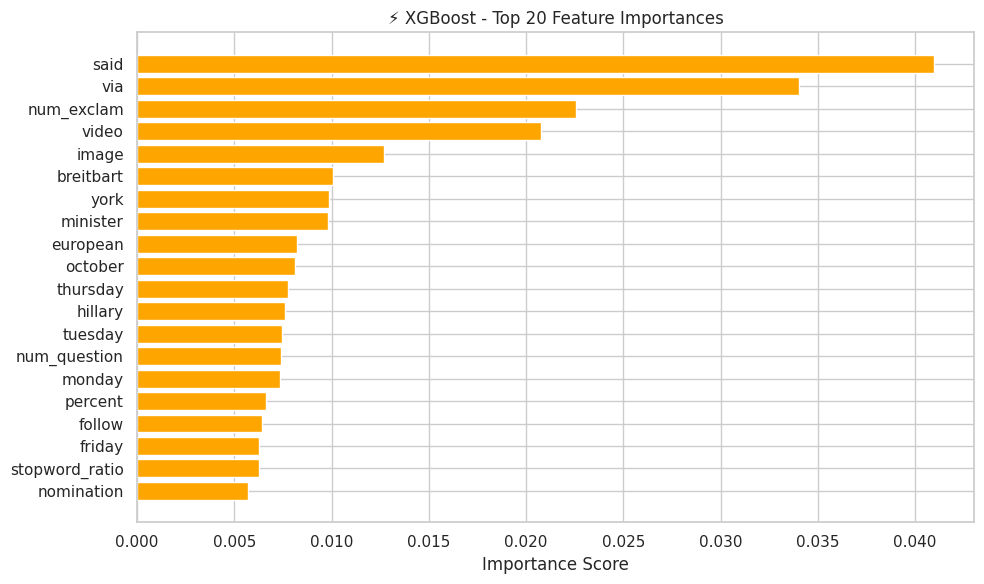

In [37]:
# Get feature importances
xgb_importances = xgb.feature_importances_

# Sort top 20 features
xgb_indices = np.argsort(xgb_importances)[-20:][::-1]
top_xgb_features = [all_feature_names[i] for i in xgb_indices]
top_xgb_importances = xgb_importances[xgb_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_xgb_features[::-1], top_xgb_importances[::-1], color='orange')
plt.xlabel("Importance Score")
plt.title("⚡ XGBoost - Top 20 Feature Importances")
plt.tight_layout()
plt.show()

In [38]:
all_feature_names = list(tfidf_feature_names) + features_to_scale

In [39]:
numeric_start_index = len(tfidf_feature_names)

<ipython-input-40-db28a2ad8d26>:7: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


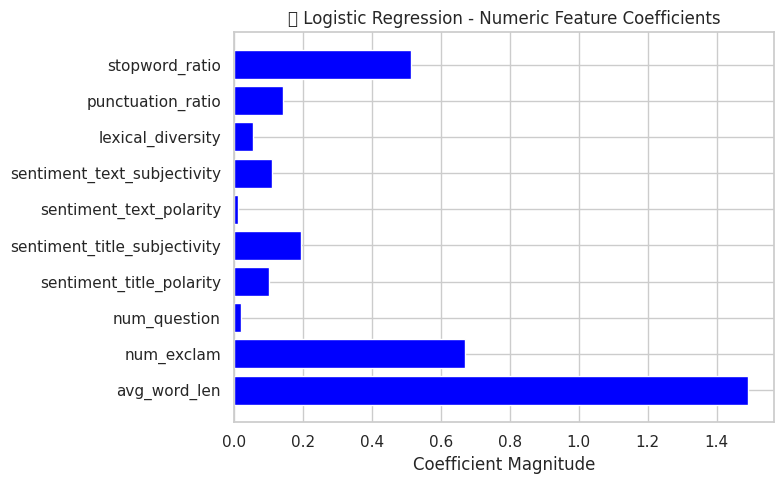

In [40]:
logreg_numeric_coefs = np.abs(logreg.coef_[0][numeric_start_index:])

plt.figure(figsize=(8, 5))
plt.barh(features_to_scale, logreg_numeric_coefs, color='blue')
plt.xlabel("Coefficient Magnitude")
plt.title("📊 Logistic Regression - Numeric Feature Coefficients")
plt.tight_layout()
plt.show()

<ipython-input-41-75f88e955781>:10: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


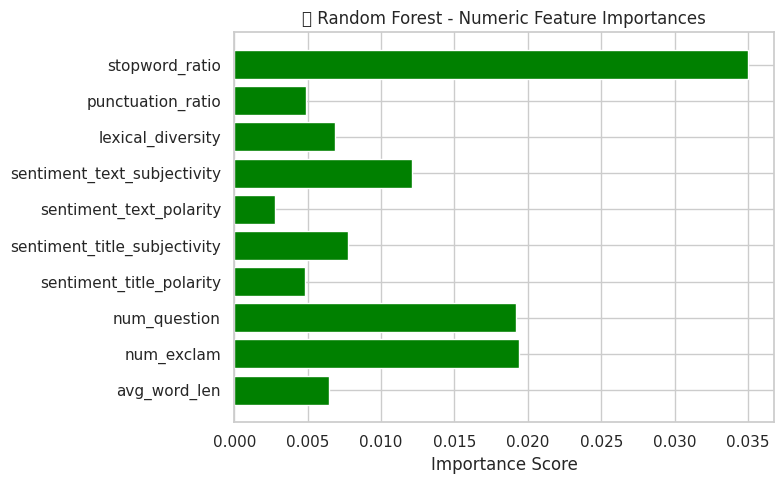

In [41]:
# Get numeric feature importances only
rf_numeric_importances = rf.feature_importances_[numeric_start_index:]
numeric_features_rf = features_to_scale

# Plot
plt.figure(figsize=(8, 5))
plt.barh(numeric_features_rf, rf_numeric_importances, color='green')
plt.xlabel("Importance Score")
plt.title("🌳 Random Forest - Numeric Feature Importances")
plt.tight_layout()
plt.show()

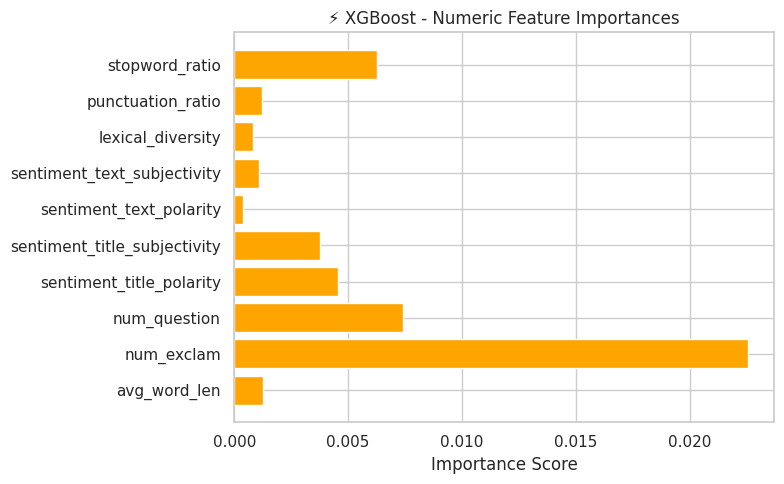

In [42]:
xgb_numeric_importances = xgb.feature_importances_[numeric_start_index:]

plt.figure(figsize=(8, 5))
plt.barh(features_to_scale, xgb_numeric_importances, color='orange')
plt.xlabel("Importance Score")
plt.title("⚡ XGBoost - Numeric Feature Importances")
plt.tight_layout()
plt.show()